## GaussianExample with original step2 method

In the original version of the GaussianExample, step2 is implemented in a simpler way than in the papers.  Instead of updating the weights in each iteration of step2, it always uses weight=1 for the gen-level sample in the compaison.

In the original OmniFold paper, they propose instead updating the weights of the previous iteration, rather than always starting from the beginning (weight=1).  I'll try to implement the original version here.


In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-01-26 20:12:55.063593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:12:55.063820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:12:55.080156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:12:55.080397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:12:55.080569: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

max_epochs = 200
batch_size_setval = 10000
learning_rate_setval = 1e-3
patience_setval = 10

back = 0.1 #fraction of a background process that we would like to subtract
background_param = (0, 1.2)  # background
N = 10**5






##-- alt1
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 3*10**5






##-- alt2
##-- more thorough set with a lot more events, higher background, wider background width 
##   About 3 hours.

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 10**6





##-- alt5
##   similar to alt4 but with sample size of 1M.
##-- more thorough set with more events, higher background, wider background width 
##  about 30 min

max_epochs = 200
batch_size_setval = 16384
learning_rate_setval = 1e-4
patience_setval = 40

back = 0.2 #fraction of a background process that we would like to subtract
background_param = (0, 3)  # background
N = 10**6



In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 4.91 s, sys: 56.6 ms, total: 4.97 s
Wall time: 4.97 s


In [9]:
theta0_G

array([-10.        ,   0.7809088 ,  -0.56505888, ...,   0.33156939,
        -0.36750336, -10.        ])

In [10]:
theta0_S

array([ 1.63726592,  0.64124504, -0.41135563, ...,  0.33854484,
       -0.60148754,  0.49806421])

In [11]:
theta0

array([[-10.        ,   1.63726592],
       [  0.7809088 ,   0.64124504],
       [ -0.56505888,  -0.41135563],
       ...,
       [  0.33156939,   0.33854484],
       [ -0.36750336,  -0.60148754],
       [-10.        ,   0.49806421]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(1000000,)

In [14]:
theta0.shape

(1000000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(1000000,)

/tmp/ipykernel_3168250/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


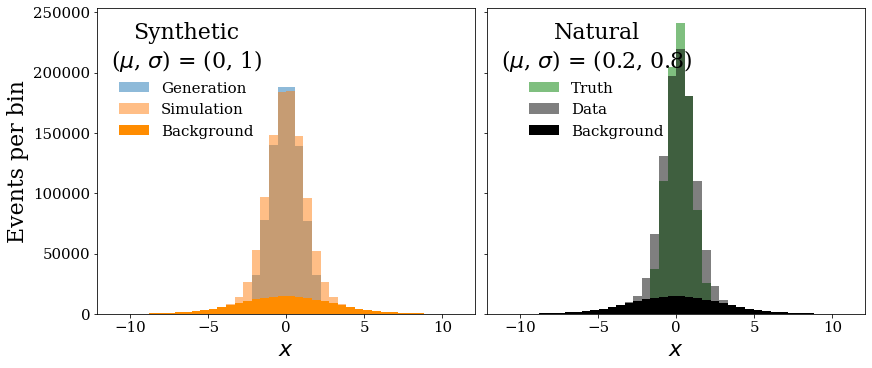

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)


nn_output = np.zeros( shape=(iterations, 2, len(theta0)))

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-01-26 20:13:01.025923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:13:01.026252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:13:01.026429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:13:01.026589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:13:01.026748: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([ 1.63726592,  0.64124504, -0.41135563, ...,  0.20327187,
        0.93358888,  0.59839889])

In [21]:
xvals_1.shape

(2000000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(2000000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 124 ms, sys: 8.19 ms, total: 132 ms
Wall time: 132 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [ ]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])


training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=100,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

In [ ]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [ ]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

In [ ]:
w_data_bgsub_only = w_data

In [ ]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [ ]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

In [ ]:
model_output_bgsub

In [ ]:
model_output_bgsub.shape

In [ ]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [ ]:
squeezed_model_output

In [ ]:
squeezed_model_output.shape

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

In [ ]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [ ]:
hist_data_all

In [ ]:
hist_data_all[0]

In [ ]:
hist_axis = hist_data_all[1]

In [ ]:
hist_axis

In [ ]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [ ]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

In [ ]:
signal_frac

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [ ]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [ ]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

#-- owen: adding this
weights_push_last_iteration = np.ones(len(theta0_S))

In [ ]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [ ]:
%%time

for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    
    
    
    weights_push_last_iteration = weights_push
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 

    ##-- owen: save NN output for each iteration, step.
    nn_output[i,0,:] = np.squeeze(  model.predict(theta0_S, batch_size=10000) )


    
    
    
    


    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)


        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,0,:] I think.  See Python-syntax-testing notebook.
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    ##-----------------------------------------------------------------------
    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.
    
    ##-- owen: this is the way it's done in the papers (I think).
    #          At this point weights_push should still have the values from the end of the last iteration.
    weights_2 = np.concatenate((weights_push, weights_pull))
    
    
    

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    #weights_push = reweight(theta0_G)    
    
    
    #-- owen: this is the way it's done in the papers (I think)
    weights_push = weights_push * reweight(theta0_G)    
    
    
    
    
    
    ##-- owen: save NN output for each iteration, step.
    nn_output[i,1,:] = np.squeeze(  model.predict(theta0_G, batch_size=10000) )
    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    

    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    

    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,1,:] I think.  See Python-syntax-testing notebook.
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    
    
    
    

In [ ]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [ ]:
weights

In [ ]:
weights.shape

In [ ]:
Input

In [ ]:
Model

In [ ]:
x_data_and_MCback

In [ ]:
x_data_and_MCback.shape

In [ ]:
y_data_and_MCback

In [ ]:
y_data_and_MCback.shape

In [ ]:
W_data_and_MCback

In [ ]:
W_data_and_MCback.shape

In [ ]:
w_data

In [ ]:
w_data.shape

In [ ]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

In [ ]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

In [ ]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()

## distributions of weights

### Weights on full simulation to match data (step1)

In [ ]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,0,theta0_S!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

### Weights on gen (step2)

In [ ]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,1,theta0_G!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on fullsim (step1) between consecutive iterations

In [ ]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], bins=80,
                 range=[-0.5,0.5])
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.5,0.5]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on gen (step2) between consecutive iterations

In [ ]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], bins=80,
                 range=[-0.2,0.2])
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.2,0.2]))
    ax[i][1].grid()
    
plt.show()

In [ ]:
nn_output

## Output of NN for step1: distinguish data from fullsim

In [ ]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,0,theta0_S!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], nn_output[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()

## NN output of step2 : distinguish gen

In [ ]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,1,theta0_G!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], nn_output[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()